In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

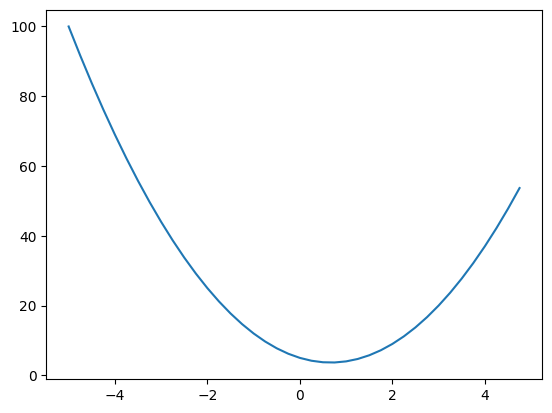

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys
plt.plot(xs, ys)

In [5]:
h = 0.000000001
x = 3.0
(f(x + h) - f(x))/h

14.000001158365194

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.000002
slope 2.000000000279556


In [99]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', tag=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.tag = tag

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(float(other), label=f'const: {other}', tag=self.tag)
        out = Value(self.data + other.data, (self, other), '+', tag=self.tag)


        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(float(other), label=f'const: {other}', tag=self.tag)
        out = Value(self.data * other.data, (self, other), '*', tag=self.tag)

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        other = float(other)
        out = Value(self.data**other, (self,), f'**{other}', tag=self.tag)

        def _backward():
            self.grad += (other * self.data**(other -1)) * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self, ), 'tanh', tag=self.tag)

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

    def exp(self):
        n = self.data
        out = Value(math.exp(n), (self, ), 'exp', tag=self.tag)

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

    
a = Value(2.0, label='a', tag='1,a')
b = Value(-3.0, label='b', tag='1,a')
c = Value(10.0, label='c', tag='2,a')
e = a*b; e.label = 'e'; e.tag='2,a'
d = e + c; d.label='d'; d.tag='3'
f = Value(-2.0, label='f', tag='3')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [6]:
from graphviz import Digraph
from collections import defaultdict

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def create_subgraph(dot, nodes, depth=0):
    if nodes:
        # Group nodes by the current tag at this depth
        grouped_nodes = defaultdict(list)
        for n in nodes:
            tags = n.tag.split(',') if n.tag else []
            if len(tags) > depth:
                grouped_nodes[tags[depth]].append(n)
            else:
                grouped_nodes[None].append(n)
        
        # Create subgraphs for each tag
        for tag, grouped in grouped_nodes.items():
            if tag is not None:
                with dot.subgraph(name='cluster_' + tag) as c:
                    c.attr(label=tag)
                    create_subgraph(c, grouped, depth + 1)
            else:
                for n in grouped:
                    uid = str(id(n))
                    dot.node(name=uid, label='{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')
                    if n._op:
                        dot.node(name=uid + n._op, label=n._op)
                        dot.edge(uid + n._op, uid)

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', "beautify": 'true'}, engine='dot')
    
    nodes, edges = trace(root)

    create_subgraph(dot, nodes)

    # Add edges
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

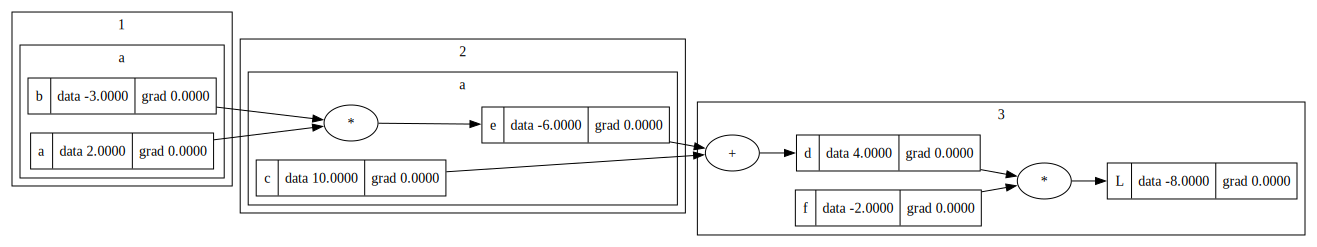

In [181]:
draw_dot(L)

In [ ]:
dL / dc

dL / dD = -2

dD / dC = 1.0
dD / dE = 1.0

dL / dE = -2.0
dL / dC = -2.0


dE/dA = B = -3.0

dL / dA = dL/dE * dE/dA
        = -2.0 * -3.0
        = -6

dL / dC = dL/ dD * dD /dC
dl / dC = -2 * 1
        = -2

d = c + e


d = c + e => d = e**c + e

dD/dC = c*e**c 


(f(x+h) - f(x))/h
((c+h + e) - (c + e)) /h



In [52]:
L.grad = 1.0
f.grad = 4
d.grad = -2
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4

In [47]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0,e label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

3.9999999999995595


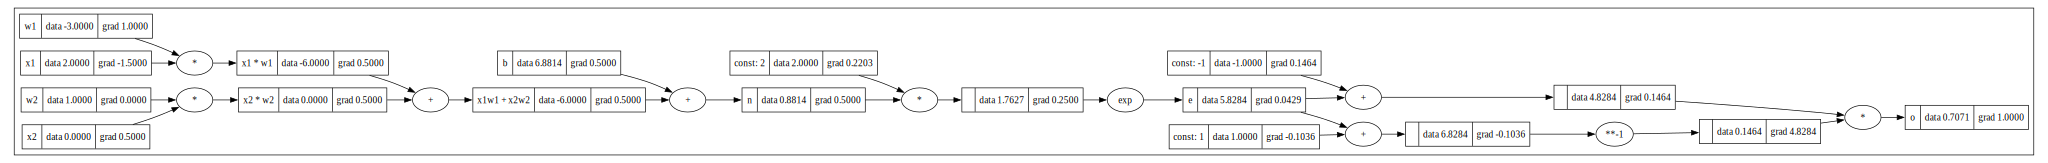

In [77]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Cell body
## Weights
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'

## Sum
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

## Add Bias
n = x1w1x2w2 + b; n.label = 'n'



#---
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
#---
#o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

In [76]:
o.grad = 1.0
o._backward()

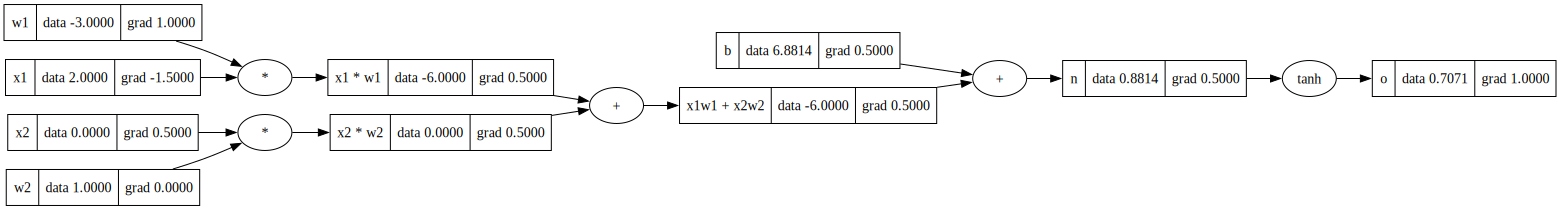

In [84]:
draw_dot(o)

In [83]:
x2w2._backward()

In [6]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [46]:
class Neuron:

    def _trace(self, root, tag):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                v.tag = tag
                for child in v._prev:
                    if child.tag != tag:
                        edges.add((child, v))
                        build(child)
        build(root)
        return nodes, edges

    def __init__(self, nin, tag=''):
        if tag == '':
            tag = str(id(self))
        else:
            tag = tag + "," +str(id(self))
        self.tag = tag
        self.w = [Value(random.uniform(-1, 1), label=f'w{i}', tag=tag) for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='b', tag=tag)

    def __call__(self, x):
        tag = self.tag
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b);
        out = act.tanh(); out.tag = tag

        self._trace(out, tag)
        
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        tag = str(id(self))
        self.neurons = [Neuron(nin, tag=tag) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        

class MultiLayerPerceptron:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [60]:
x = [2.0, 3.0, -1.0]
n = MultiLayerPerceptron(3, [4, 4, 1])

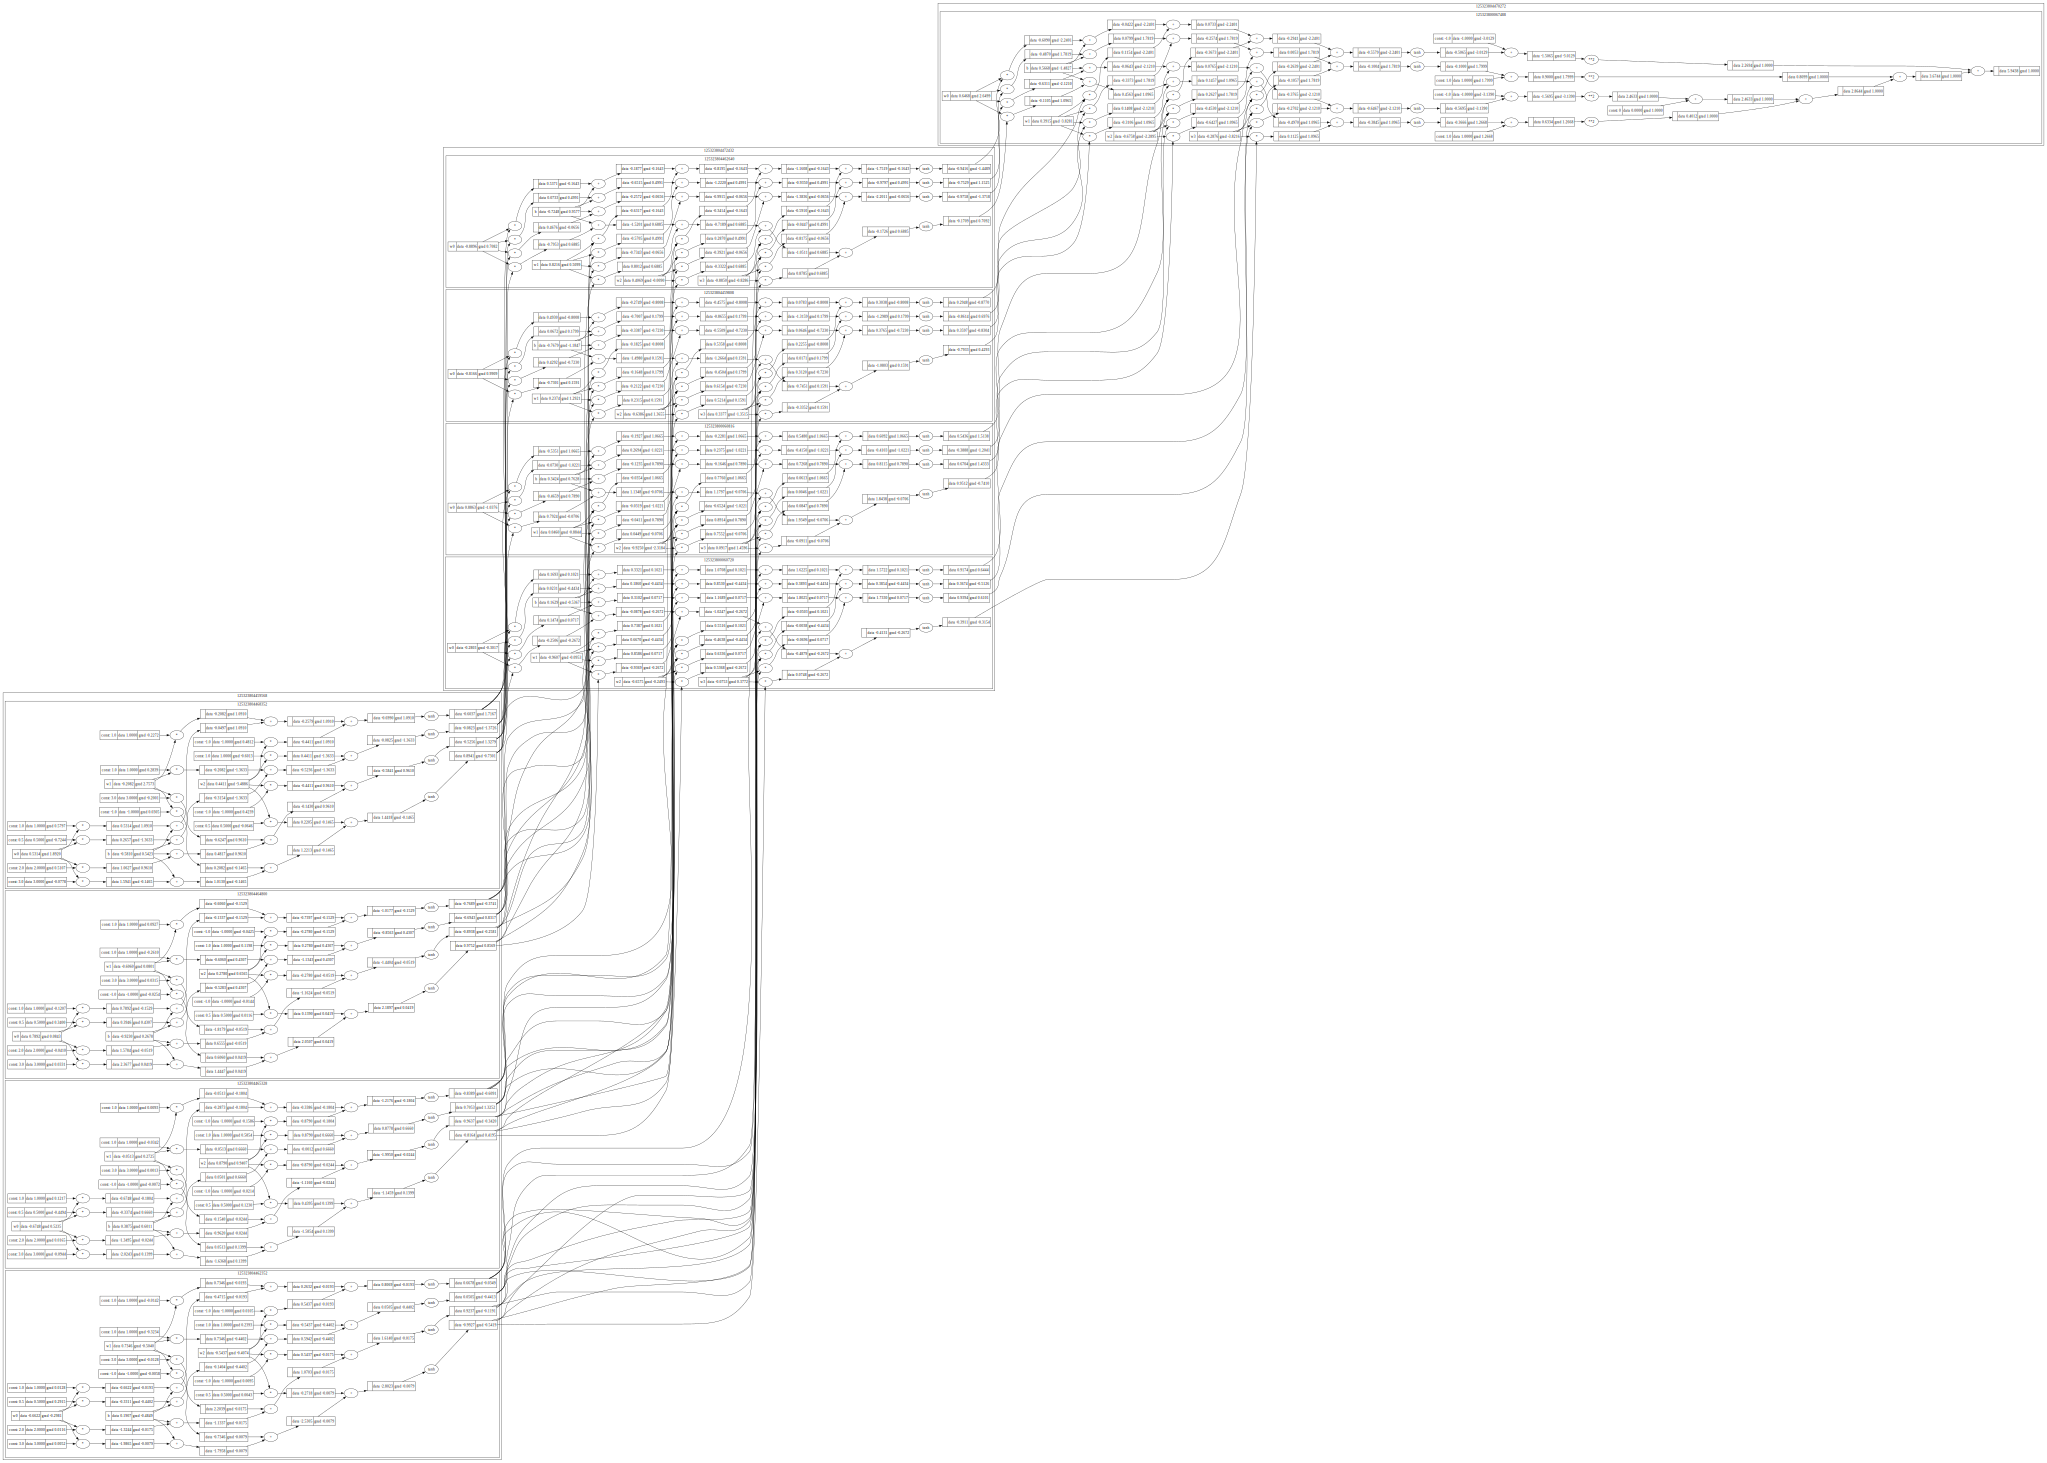

In [54]:
draw_dot(loss)

In [61]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]


In [50]:
ypred = [n(x) for x in xs]
ypred
loss = sum([(yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.943750954828017)

In [51]:
loss.backward()

In [48]:
len(n.parameters())

41

In [53]:
n.layers[0].neurons[0].w[0]

Value(data=0.5313611318967537)

In [55]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [56]:
n.layers[0].neurons[0].w[0]

Value(data=0.5124414776083861)

In [57]:
ypred = [n(x) for x in xs]
loss = sum([(yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.99312518653077)

In [72]:
loss = Value(1000)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

n = MultiLayerPerceptron(3, [4, 4, 1])

while loss.data > 0.1:
    ypred = [n(x) for x in xs]
    loss = sum([(yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred)])
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    if loss.data < 0.1:
        break
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(loss.data)

5.646568972964697
4.343838371619655
3.844855948976904
3.6440265684099926
3.484553837061036
3.323589713485254
3.1449853109492194
2.933981399113531
2.6699727264662823
2.3201052679918845
1.8441552860339283
1.2637734343899247
0.7573017259167908
0.4551476830523029
0.2998383119642093
0.2158737200066742
0.16582463989748886
0.1333559980863722
0.1108723561970498


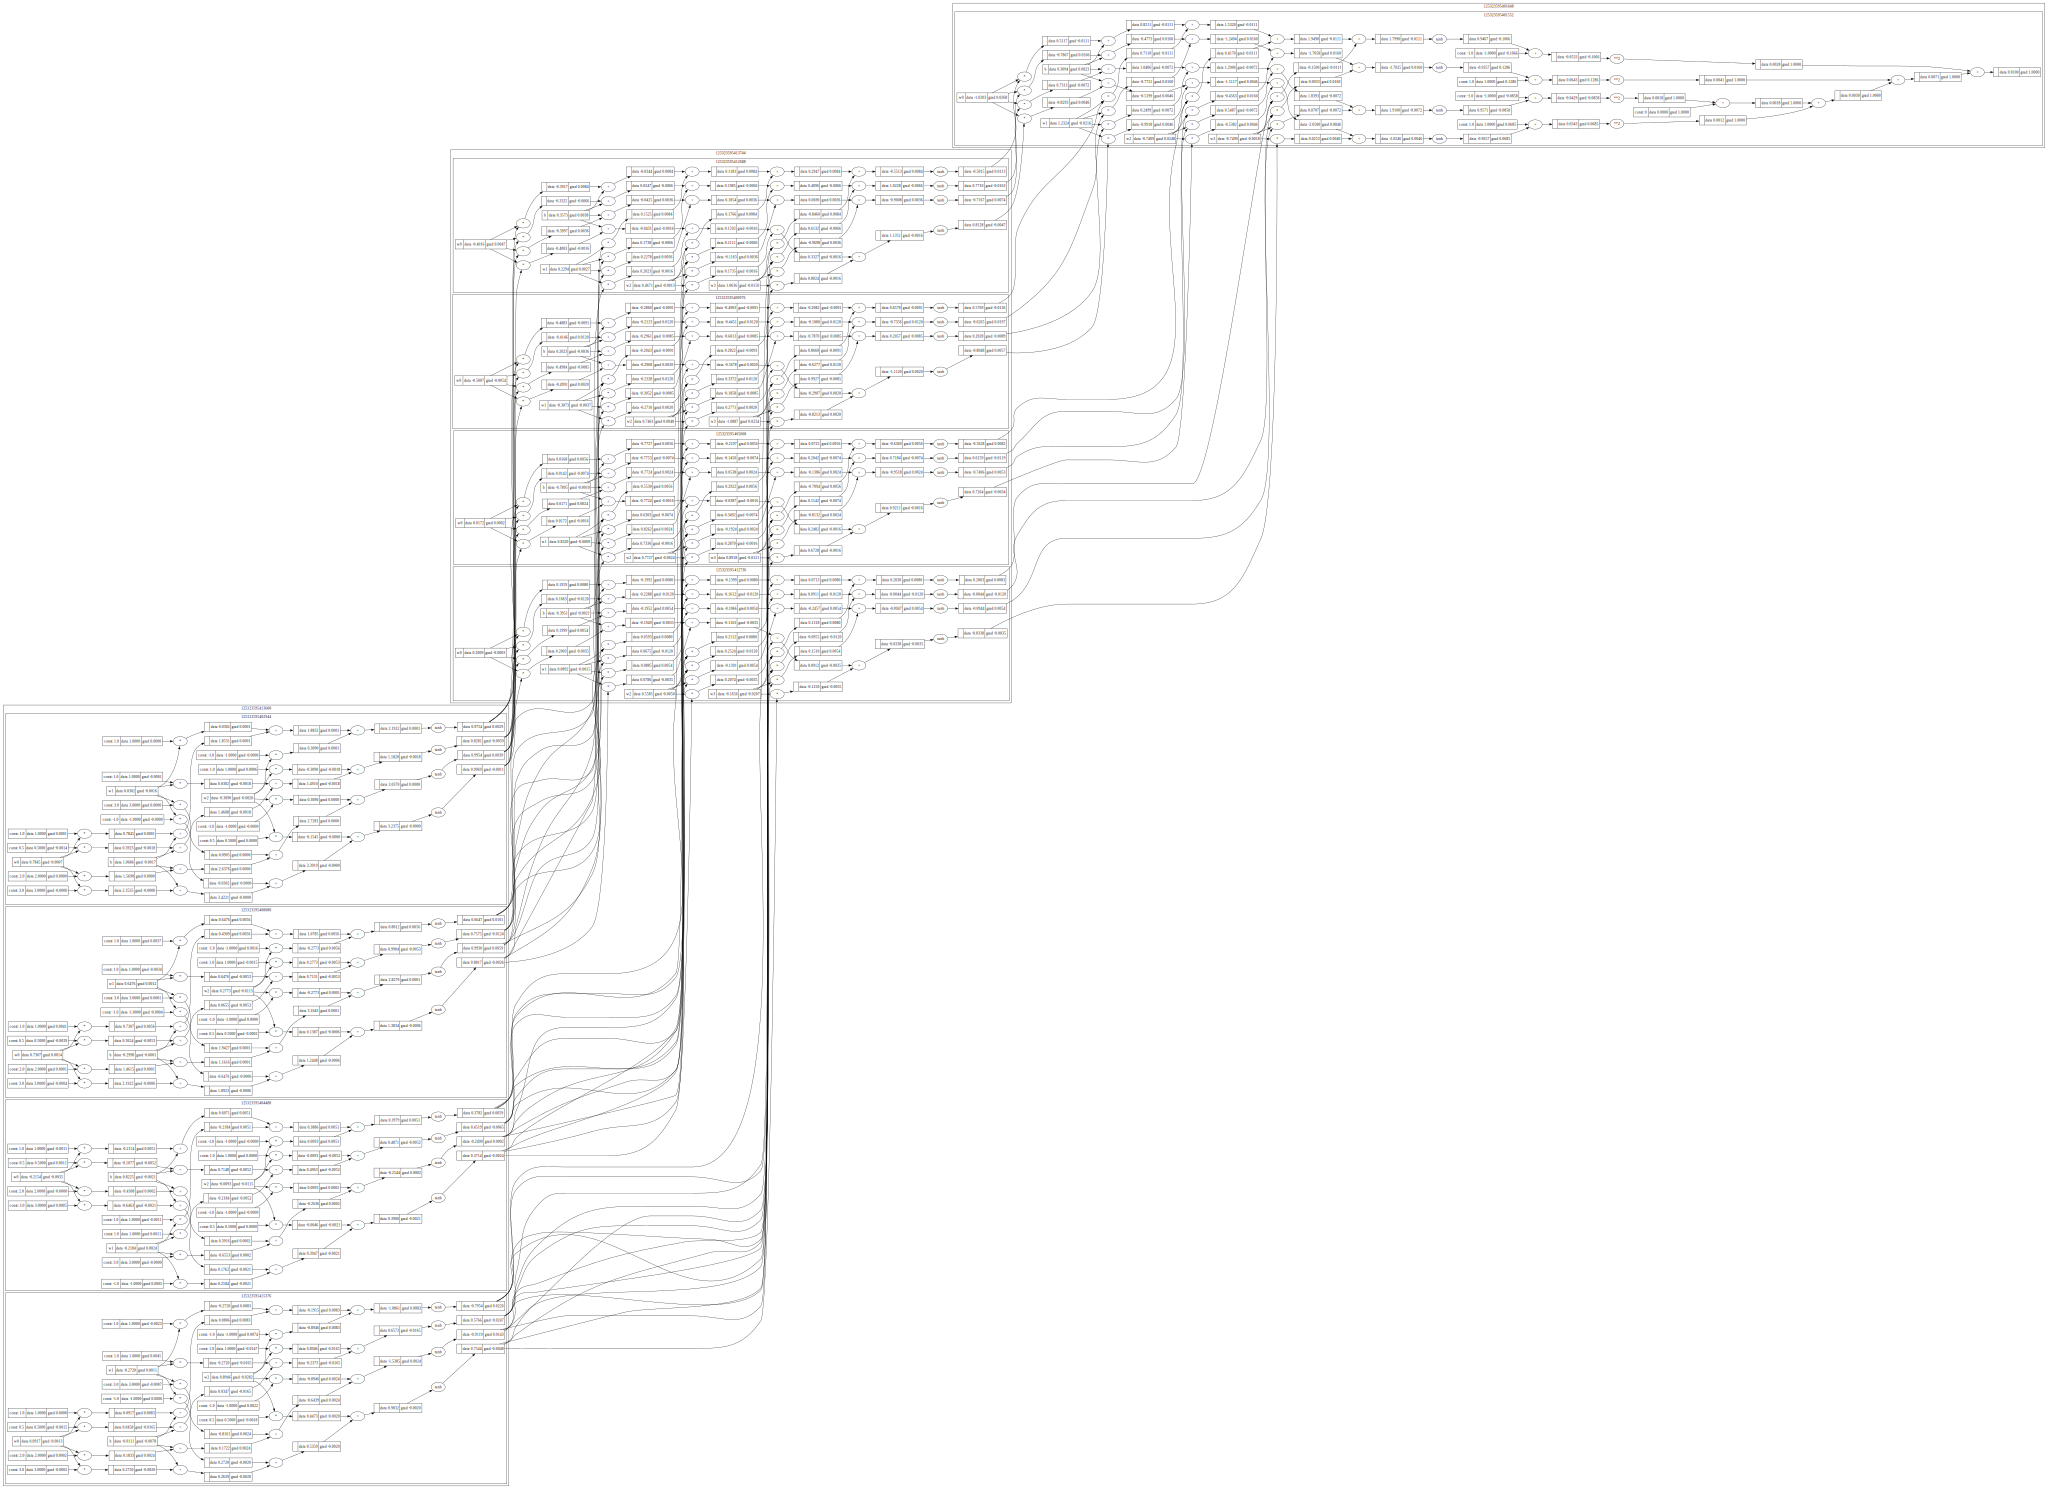

In [67]:
draw_dot(loss)

In [64]:
ypred

[[Value(data=0.9906417245025206)],
 [Value(data=-0.9949550627071616)],
 [Value(data=-0.9094793784261103)],
 [Value(data=0.9785820585729986)]]

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


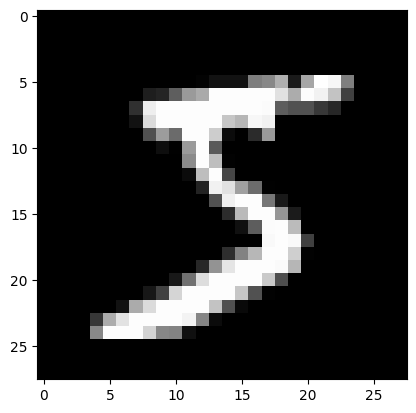

In [78]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

# Use responsibly! When running notebooks locally, be sure to keep local
# copies of the datasets to prevent unnecessary server requests
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0"
}
request_opts = {
    "headers": headers,
    "params": {"raw": "true"},
}

import requests
import os

data_dir = "../_data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://github.com/rossbar/numpy-tutorial-data-mirror/blob/main/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True, **request_opts)
        resp.raise_for_status()  # Ensure download was succesful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)

import gzip

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

print(
    "The shape of training images: {} and training labels: {}".format(
        x_train.shape, y_train.shape
    )
)
print(
    "The shape of test images: {} and test labels: {}".format(
        x_test.shape, y_test.shape
    )
)

# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[0, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()

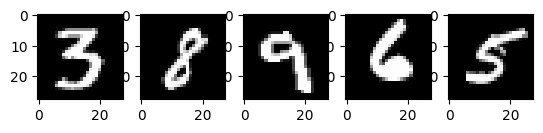

In [74]:
num_examples = 5
seed = 147197952744
rng = np.random.default_rng(seed)

fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(rng.choice(x_train, size=num_examples, replace=False), axes):
    ax.imshow(sample.reshape(28, 28), cmap="gray")

In [102]:
np.divide(x_train, 255.0)[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [83]:
y_train[1]

np.uint8(0)

In [103]:
dataMap = {}

for i in range(10):
    a = [0] * 10
    a[i] = 1
    dataMap[i] = a


ys = []
for y in y_train:
    ys.append(dataMap[y])

xs = np.divide(x_train, 255.0).tolist()

In [ ]:
loss = Value(1000)

n = MultiLayerPerceptron(784, [16, 10])

while loss.data > 0.1:
    ypred = [n(x) for x in xs]
    loss = sum([(yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred)])
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    if loss.data < 0.1:
        break
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(loss.data)